In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import mediapipe as mp

# to annotate https://www.makesense.ai/
# https://www.sciencedirect.com/science/article/pii/S2352648320300362?via%3Dihub
# https://towardsdatascience.com/creating-a-snapchat-style-filter-with-python-b42ecfd2ff54?gi=b593a3b182f8

In [22]:
face_img = cv2.imread("/home/roland/Downloads/face.jpg")
face_img_copy = face_img.copy()
mask_img = cv2.imread("/home/roland/Downloads/mask_blue.png", -1)
mask_img_copy = mask_img.copy()
mask_annotation = np.genfromtxt('/home/roland/Downloads/mask_blue.csv', delimiter=',', dtype=int)
mask_annotation = np.delete(mask_annotation, [0,3,4,5], axis=1) #get the (x,y) of annotations
print(mask_annotation)

[[ 34  61]
 [466  57]
 [246  33]
 [318  44]
 [163  44]
 [ 39 149]
 [463 168]
 [451 258]
 [ 46 255]
 [ 92 316]
 [415 320]
 [137 372]
 [362 374]
 [183 420]
 [310 423]
 [250 441]]


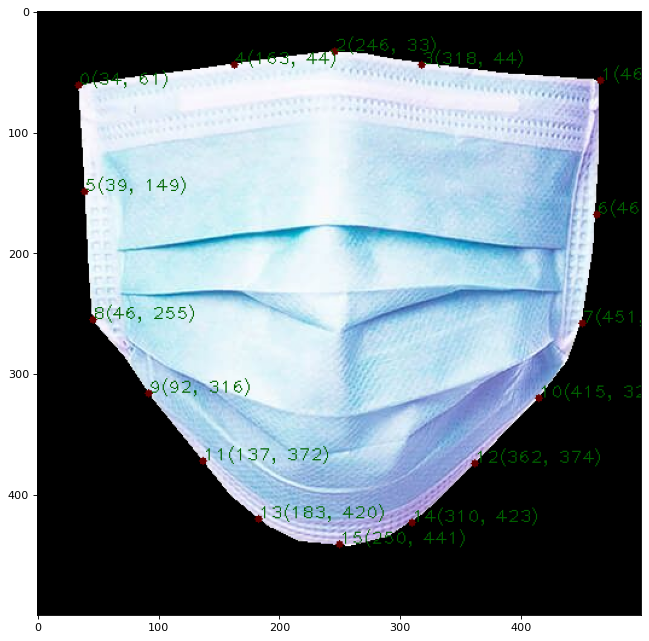

In [23]:
m_height, m_width = face_img.shape[:2]
for idx, xy in enumerate(mask_annotation):
    cv2.circle(mask_img_copy, (xy[0], xy[1]), 3, (0,0,100), -1)
    cv2.putText(mask_img_copy, str(idx) + f"{xy[0], xy[1]}", (xy[0],xy[1]), 1, 1, (0,100,0))

plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(cv2.cvtColor(mask_img_copy, cv2.COLOR_BGR2RGB))    

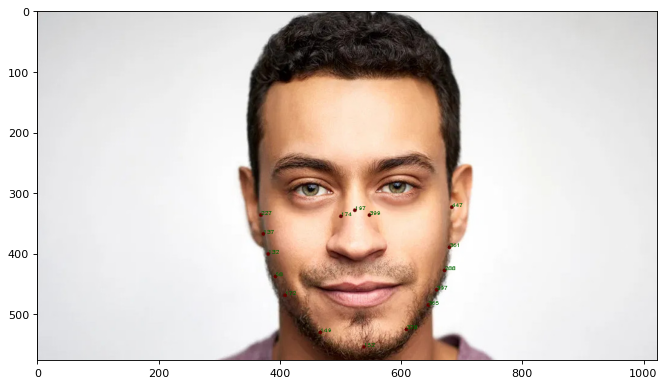

In [13]:
face_mesh_model = mp.solutions.face_mesh.FaceMesh()
face_landmarks = face_mesh_model.process(face_img)

f_height, f_width = face_img.shape[:2]
# 16 handpicked face landmark indices (out of 468) corresponding to the points in the mask.
landmarks_for_mask = [227, 447, 197, 399, 174, 132, 361, 288, 58, 172, 397, 137, 365, 149, 378, 152] 
landmarks_for_mask = [227, 447, 197, 399, 174, 132, 361, 288, 58, 172, 397, 137, 365, 149, 378, 152] 


for face in face_landmarks.multi_face_landmarks:
    # for i in range(0, 468):
    #     landmark = face.landmark[i]
    #     x = int(landmark.x * width)
    #     y = int(landmark.y * height)
    #     cv2.circle(face_img_copy, (x,y), 3, (0,0,100), -1) # img, location, size of circle, color, fill with color
    #     cv2.putText(face_img_copy, str(i), (x,y), 1, 1, (0,100,0)) # img, text, locaiton, font, size, color

    face_annotation = []
    for i in landmarks_for_mask:
        landmark = face.landmark[i]
        xy = int(landmark.x * f_width), int(landmark.y * f_height)
        face_annotation.append(np.array(xy))

        # draw the points on the copy image
        cv2.circle(face_img_copy, xy, 3, (0,0,100), -1)
        cv2.putText(face_img_copy, str(i), xy, 1, 0.6, (0,100,0)) 
    
    face_annotation = np.array(face_annotation)
        
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(cv2.cvtColor(face_img_copy, cv2.COLOR_BGR2RGB))    
# plt.savefig('landmark.png')

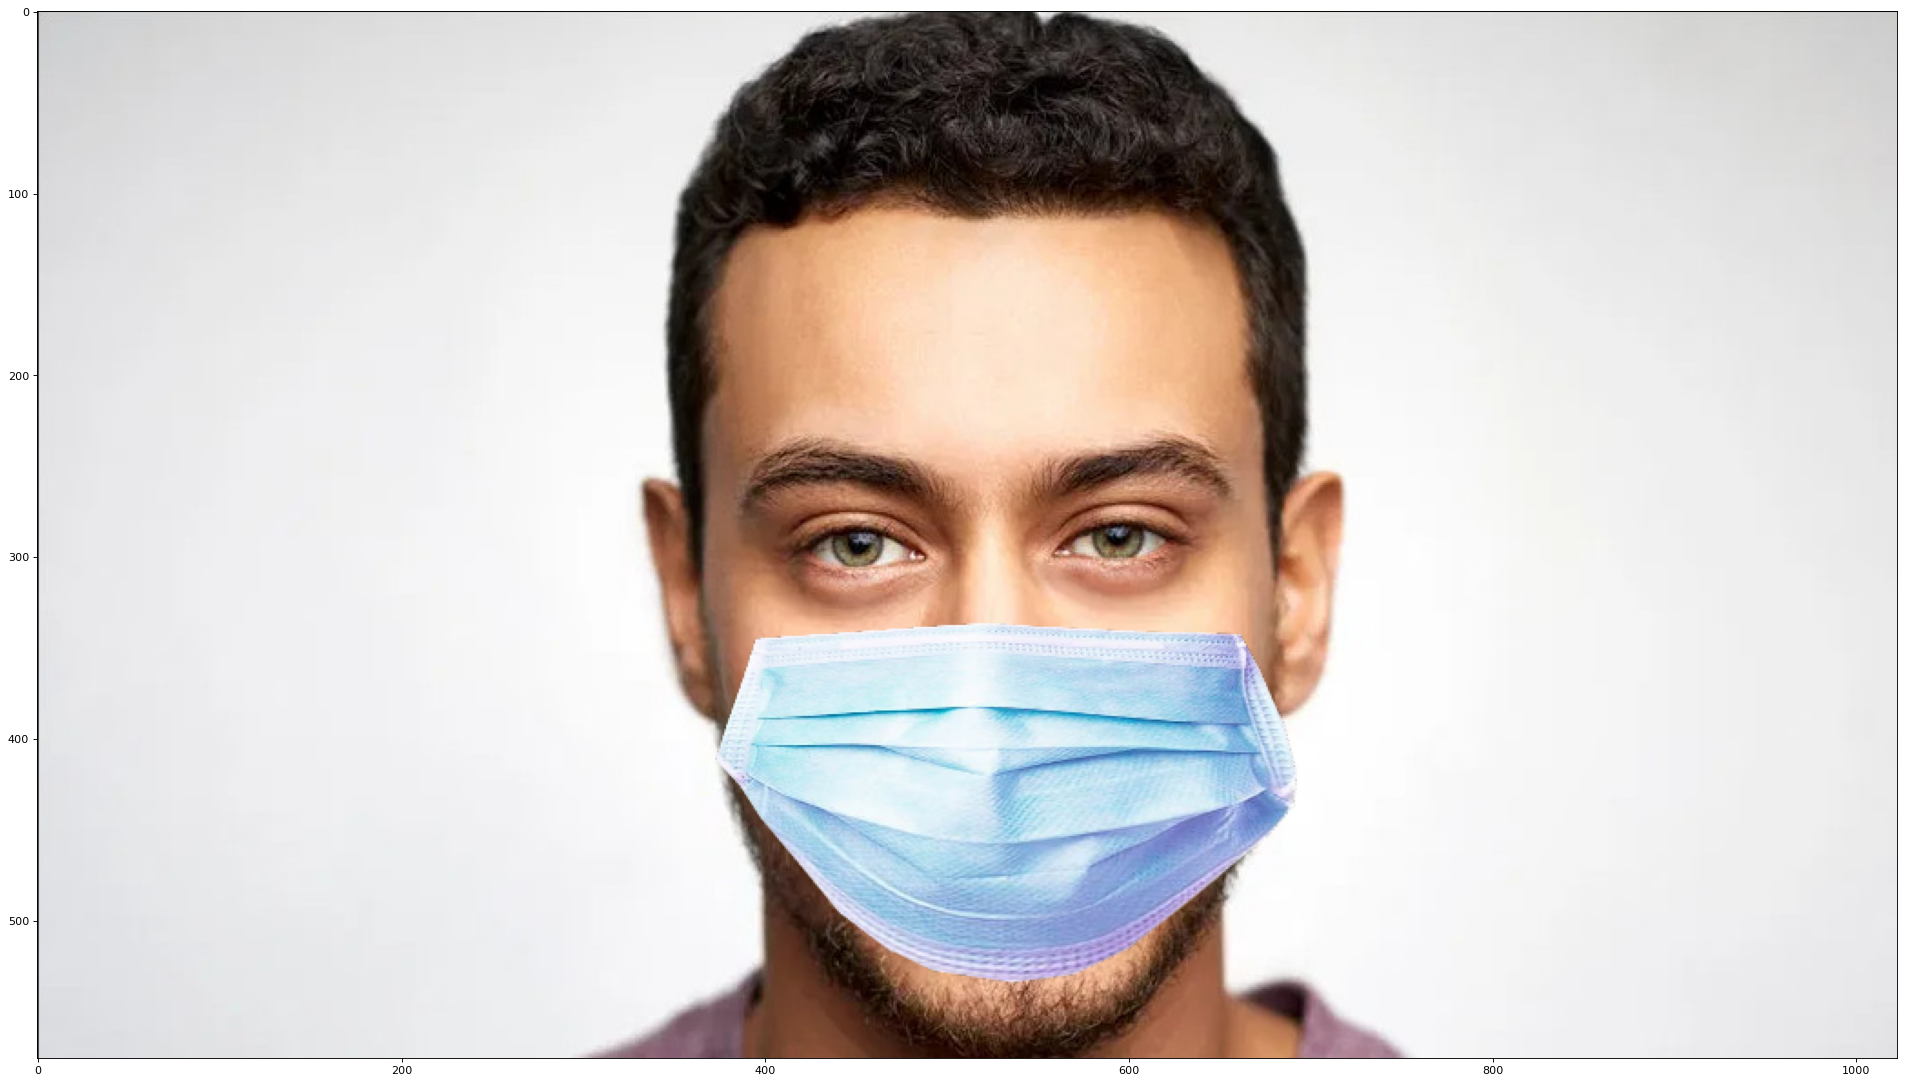

In [14]:
hom = cv2.findHomography(mask_annotation, face_annotation)[0]
warped = cv2.warpPerspective(mask_img, hom, (f_width, f_height))
mask = warped[:,:, 3]
mask_scale = mask.copy() / 255.0
mask_scale = np.dstack([mask_scale] * 3)    
# Remove the alpha channel from the warped image
warped = cv2.cvtColor(warped, cv2.COLOR_BGRA2BGR)

warped_multiplied = cv2.multiply(mask_scale, warped.astype("float"))
image_multiplied = cv2.multiply(face_img.astype(float), 1.0 - mask_scale)
output = cv2.add(warped_multiplied, image_multiplied)
output = output.astype("uint8")

plt.figure(figsize=(30, 30), dpi=80)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))   